In [2]:
import pickle
import re
import os

import random
import numpy as np
import pandas as pd
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import logging


from util.args_parser import parser
from model.QACGBERT import BertConfig
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import (Sentihood_NLI_M_Processor,
                            Semeval_NLI_M_Processor)

from util.tokenization import *

from util.evaluation import *

from model.QACGLONG import *

ModuleNotFoundError: No module named 'torch'

In [4]:
df = pd.read_csv("../datasets/persent/dev_longformer_topic.csv")
df.head()

,DOCUMENT_INDEX,TITLE,TARGET_ENTITY,DOCUMENT,MASKED_DOCUMENT,TRUE_SENTIMENT,Paragraph0,Paragraph1,Paragraph2,Paragraph3,...,Paragraph10,Paragraph11,Paragraph12,Paragraph13,Paragraph14,Paragraph15,prob_max,topic,group,context
0,3360,AS VALUES DROP MORE HOMEOWNERS WALKING AWAY FR...,Benjamin Koellmann,In 2006 Benjamin Koellmann bought a condomini...,In 2006 [TGT] bought a condominium in Miami B...,Neutral,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,0.261895,rec.autos,general,[TGT] - general
1,3360,AS VALUES DROP MORE HOMEOWNERS WALKING AWAY FR...,Benjamin Koellmann,In 2006 Benjamin Koellmann bought a condomini...,In 2006 [TGT] bought a condominium in Miami B...,None,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,0.261895,rec.autos,politics,[TGT] - politics
2,3360,AS VALUES DROP MORE HOMEOWNERS WALKING AWAY FR...,Benjamin Koellmann,In 2006 Benjamin Koellmann bought a condomini...,In 2006 [TGT] bought a condominium in Miami B...,None,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,0.261895,rec.autos,reaction,[TGT] - reaction
3,3360,AS VALUES DROP MORE HOMEOWNERS WALKING AWAY FR...,Benjamin Koellmann,In 2006 Benjamin Koellmann bought a condomini...,In 2006 [TGT] bought a condominium in Miami B...,None,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,0.261895,rec.autos,computer,[TGT] - computer
4,3360,AS VALUES DROP MORE HOMEOWNERS WALKING AWAY FR...,Benjamin Koellmann,In 2006 Benjamin Koellmann bought a condomini...,In 2006 [TGT] bought a condominium in Miami B...,None,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,0.261895,rec.autos,religion,[TGT] - religion


In [9]:
df = pd.read_excel("../datasets/longformer_20news.xlsx")
df.head()

,Step,Training Loss,Validation Loss,Accuracy
0,4,3.0038,3.003272,0.050319
1,8,3.0036,3.002958,0.050186
2,12,3.0098,3.001984,0.051248
3,16,3.0084,3.000390,0.051912
4,20,3.0111,2.998500,0.052841


<AxesSubplot:>

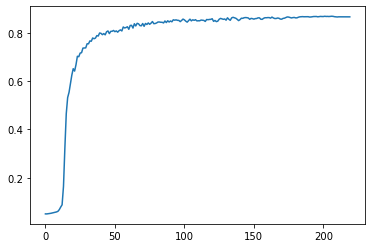

In [10]:
df['Accuracy'].plot()

In [2]:
processors = {
    "sentihood_NLI_M":Sentihood_NLI_M_Processor,
    "semeval_NLI_M":Semeval_NLI_M_Processor
}

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig



In [3]:
data_train = fetch_20newsgroups(subset='train', shuffle=True)
data_test = fetch_20newsgroups(subset='test', shuffle=True)

In [4]:
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length=2048)

train_encodings = tokenizer(data_train.data, truncation=True, padding=True, max_length=2048)
valid_encodings = tokenizer(data_test.data, truncation=True, padding=True, max_length=2048)

class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = NewsGroupsDataset(train_encodings, data_train.target)
valid_dataset = NewsGroupsDataset(valid_encodings, data_test.target)



Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


In [12]:
input_ids = train_dataset[:]['input_ids']
attn_masks = train_dataset[:]['attention_mask']

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=20, gradient_checkpointing=False, attention_window = 512)


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', '

In [ ]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attn_masks)

In [7]:
model

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc,}

In [9]:
training_args = TrainingArguments(
    output_dir = '../results/sentihood/NewsGroups/',
    num_train_epochs = 5,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8,    
    per_device_eval_batch_size= 1,
    evaluation_strategy = "steps",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps = 4,
    logging_dir='../results/sentihood/NewsGroups/logs',
    dataloader_num_workers = 0,
    run_name = 'longformer-classification-updated-rtx3090_paper_replication_2_warm'
)

In [10]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [11]:
trainer.train()

/Users/haoyuzhu/opt/anaconda3/envs/torch1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11314
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 7070
Initializing global attention on CLS token...


KeyboardInterrupt: 

### Set up system (device and GPU)

In [3]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

def system_setups(args):
    # system related setups
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        n_gpu = torch.cuda.device_count()
    else:
        device = torch.device("cuda", args.local_rank)
        n_gpu = 1
        # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.distributed.init_process_group(backend='nccl')
    logger.info("device %s n_gpu %d distributed training %r", device, n_gpu, bool(args.local_rank != -1))

    if args.accumulate_gradients < 1:
        raise ValueError("Invalid accumulate_gradients parameter: {}, should be >= 1".format(
                            args.accumulate_gradients))

    args.train_batch_size = int(args.train_batch_size / args.accumulate_gradients)

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if args.bert_config_file is not None:
        bert_config = BertConfig.from_json_file(args.bert_config_file)
        if args.max_seq_length > bert_config.max_position_embeddings:
            raise ValueError(
                "Cannot use sequence length {} because the BERT model was only trained up to sequence length {}".format(
                args.max_seq_length, bert_config.max_position_embeddings))

    # not preloading
    if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    os.makedirs(args.output_dir, exist_ok=True)

    output_log_file = os.path.join(args.output_dir, "log.txt")
    print("output_log_file=",output_log_file)

    if args.task_name == "sentihood_NLI_M":
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\tstrict_acc\tf1\tauc\ts_acc\ts_auc\n")
    else:
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\taspect_P\taspect_R\taspect_F\ts_acc_4\ts_acc_3\ts_acc_2\n")

    return device, n_gpu, output_log_file

### Pass arguments

In [4]:
args_init = ['--task_name', 'sentihood_NLI_M', 
             '--data_dir', '../datasets/sentihood/',
             '--output_dir', '../results/sentihood/QACGLONG-reproduce1/',
             '--model_type', 'QACGLONG',
             '--do_lower_case',
             '--max_seq_length', '2048',
             '--train_batch_size', '64',
             '--eval_batch_size', '128',
             '--learning_rate', '2e-5',
             '--num_train_epochs', '1',
             '--vocab_file', 'BERT-Google/vocab.txt',
             '--bert_config_file', 'Longformer/config.json',
             '--init_checkpoint', 'Longformer/pytorch_model.bin',
             '--seed', '123',
             '--evaluate_interval', '200']

args = parser.parse_args(args_init)

In [5]:
device, n_gpu, output_log_file= system_setups(args)

05/23/2022 23:53:16 - INFO - __main__ -   device cpu n_gpu 0 distributed training False


output_log_file= ../results/sentihood/QACGLONG-reproduce1/log.txt


### Get model, optimizer and tokenizer (but "model" more useful here)

In [6]:
def getModelOptimizerTokenizer(model_type, vocab_file,
                               bert_config_file=None, init_checkpoint=None,
                               label_list=None,
                               do_lower_case=True,
                               num_train_steps=None,
                               learning_rate=None,
                               base_learning_rate=None,
                               warmup_proportion=None,
                               init_lrp=False):

    # this is the model we develop
    tokenizer = FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case, pretrain=False)
    if bert_config_file is not None:
        bert_config = BertConfig.from_json_file(bert_config_file)
    else:
        # default?
        print("else implemented")
        bert_config = BertConfig(
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=512,
            type_vocab_size=2,
            initializer_range=0.02
        )
    logger.info("*** Model Config ***")
    logger.info(bert_config.to_json_string())
    # overwrite the vocab size to be exact. this also save space incase
    # vocab size is shrinked.
    bert_config.vocab_size = len(tokenizer.vocab)
    # model and optimizer
    logger.info("model = QACGLONG")
    model = QACGBertForSequenceClassification1(
                    bert_config, len(label_list),
                    init_weight=True,
                    init_lrp=init_lrp)

    if init_checkpoint is not None:
        print(init_checkpoint)
        logger.info("retraining with saved model.")
        # only load fields that are avaliable
        model.bert.load_state_dict(torch.load(init_checkpoint, map_location='cpu'), strict=False)
    no_decay = ['bias', 'gamma', 'beta']
    block_list = []
    
    optimizer_parameters = [
        {'params': [p for n, p in model.named_parameters() 
            if not any(nd in n for nd in no_decay) and not any(bl in n for bl in block_list)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in model.named_parameters() 
            if any(nd in n for nd in no_decay) and not any(bl in n for bl in block_list)], 'weight_decay_rate': 0.0}
        ]

    optimizer = BERTAdam(optimizer_parameters,
                        lr=learning_rate,
                        warmup=warmup_proportion,
                        t_total=num_train_steps)
    return model, optimizer, tokenizer

In [7]:
processor = processors[args.task_name]()
label_list = processor.get_labels()

# training setup
train_examples = None
num_train_steps = None
train_examples = processor.get_train_examples(args.data_dir)
num_train_steps = int(len(train_examples) / args.train_batch_size * args.num_train_epochs)

# model and optimizer
model1, optimizer, tokenizer = getModelOptimizerTokenizer(model_type=args.model_type,
                                   vocab_file=args.vocab_file,
                                   bert_config_file=args.bert_config_file,
                                   init_checkpoint=args.init_checkpoint,
                                   label_list=label_list,
                                   do_lower_case=True,
                                   num_train_steps=num_train_steps,
                                   learning_rate=args.learning_rate,
                                   base_learning_rate=args.base_learning_rate,
                                   warmup_proportion=args.warmup_proportion)

05/23/2022 23:53:18 - INFO - __main__ -   *** Model Config ***
05/23/2022 23:53:18 - INFO - __main__ -   {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "full_pooler": false,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "type_vocab_size": 2,
  "vocab_size": 50265
}

05/23/2022 23:53:18 - INFO - __main__ -   model = QACGLONG


init_weight = True


05/23/2022 23:53:20 - INFO - __main__ -   retraining with saved model.


Longformer/pytorch_model.bin


### Obtain training features (extended length to 2048)

In [8]:
context_id_map_sentihood = {'location - 1 - general':0,
                            'location - 1 - price':1,
                            'location - 1 - safety':2,
                            'location - 1 - transit location':3,
                            'location - 2 - general':4,
                            'location - 2 - price':5,
                            'location - 2 - safety':6,
                            'location - 2 - transit location':7}

context_id_map_semeval= {'price':0,
                         'anecdotes':1,
                         'food':2,
                         'ambience':3,
                         'service':4}

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, seq_len,
                 context_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.seq_len = seq_len
        # extra fields to hold context
        self.context_ids = context_ids            

def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, max_context_length,
                                 # if this is true, the context will not be
                                 # appened into the inputs
                                 context_standalone, args):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(tqdm(examples)):
        temp = example.text_a * 1000
        tokens_a = tokenizer.tokenize(temp)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
        # tokens of context
        tokens_context = None
        if example.text_b:
            tokens_context = tokens_b

        if tokens_b and not context_standalone:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b and not context_standalone:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        context_ids = []
        if tokens_context:
            # let us encode context into single int
            if args.task_name == "sentihood_NLI_M":
                context_ids = [context_id_map_sentihood[example.text_b]]
            else:
                context_ids = [context_id_map_semeval[example.text_b]]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        seq_len = len(input_ids)
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        while len(context_ids) < max_context_length:
            context_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(context_ids) == max_context_length

        label_id = label_map[example.label]

        features.append(
                InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_id=label_id,
                        seq_len=seq_len,
                        # newly added context part
                        context_ids=context_ids))
    
    return features

In [9]:
# training set
train_features = convert_examples_to_features(
        train_examples[:100], label_list, args.max_seq_length,
        tokenizer, args.max_context_length,
        args.context_standalone, args)

100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


In [10]:
input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
seq_len = torch.tensor([[f.seq_len] for f in train_features], dtype=torch.long)
context_ids = torch.tensor([f.context_ids for f in train_features], dtype=torch.long)

In [11]:
max_seq_lens = max(seq_len)[0]
input_ids = input_ids[:10,:max_seq_lens]
input_mask = input_mask[:10,:max_seq_lens]
segment_ids = segment_ids[:10,:max_seq_lens]
label_ids = label_ids[:10]
seq_len = seq_len[:10, :]
context_ids = context_ids[:10,:]

input_ids = input_ids.to(device)
input_mask = input_mask.to(device)
segment_ids = segment_ids.to(device)
label_ids = label_ids.to(device)
seq_len = seq_len.to(device)
context_ids = context_ids.to(device)

In [12]:
model1.to(device)

QACGBertForSequenceClassification1(
  (bert): ContextBertModel1(
    (embeddings): BERTEmbeddings1(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BERTLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ContextBERTEncoder1(
      (context_layer): ModuleList(
        (0): Linear(in_features=1536, out_features=768, bias=True)
        (1): Linear(in_features=1536, out_features=768, bias=True)
        (2): Linear(in_features=1536, out_features=768, bias=True)
        (3): Linear(in_features=1536, out_features=768, bias=True)
        (4): Linear(in_features=1536, out_features=768, bias=True)
        (5): Linear(in_features=1536, out_features=768, bias=True)
        (6): Linear(in_features=1536, out_features=768, bias=True)
        (7): Linear(in_features=1536, out_features=768, bias=True)
        (8): Linear(in_features=1536, out_fe

### Simply run model once

In [ ]:
output = model1(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_mask, seq_lens=seq_len, device=device, labels=label_ids, context_ids=context_ids)


In [ ]:
output

In [3]:
train_data = pd.read_csv('../datasets/train.csv')
train_data = train_data[['DOCUMENT', 'TARGET_ENTITY', 'TRUE_SENTIMENT']]

In [4]:
train_data.head()

,DOCUMENT,TARGET_ENTITY,TRUE_SENTIMENT
0,Germany's Landesbank Baden Wuertemberg won EU ...,Landesbank Baden Wuertemberg,Negative
1,The Philippine National Police (PNP) identifie...,Rolando Mendoza,Neutral
2,Sirleaf 70 acknowledged before the commissio...,Charles Taylor,Negative
3,Sawyer logged off and asked her sister Mari ...,Sawyers,Neutral
4,Candi Holyfield said in the protective order t...,Candi Holyfield,Neutral


In [5]:
processors = {
    "sentihood_NLI_M":Sentihood_NLI_M_Processor,
    "semeval_NLI_M":Semeval_NLI_M_Processor
}

In [5]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

def system_setups(args):
    # system related setups
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        n_gpu = torch.cuda.device_count()
    else:
        device = torch.device("cuda", args.local_rank)
        n_gpu = 1
        # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.distributed.init_process_group(backend='nccl')
    logger.info("device %s n_gpu %d distributed training %r", device, n_gpu, bool(args.local_rank != -1))

    if args.accumulate_gradients < 1:
        raise ValueError("Invalid accumulate_gradients parameter: {}, should be >= 1".format(
                            args.accumulate_gradients))

    args.train_batch_size = int(args.train_batch_size / args.accumulate_gradients)

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if args.bert_config_file is not None:
        bert_config = BertConfig.from_json_file(args.bert_config_file)
        if args.max_seq_length > bert_config.max_position_embeddings:
            raise ValueError(
                "Cannot use sequence length {} because the BERT model was only trained up to sequence length {}".format(
                args.max_seq_length, bert_config.max_position_embeddings))

    # not preloading
    if os.path.exists(args.output_dir) and os.listdir(args.output_dir):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    os.makedirs(args.output_dir, exist_ok=True)

    output_log_file = os.path.join(args.output_dir, "log.txt")
    print("output_log_file=",output_log_file)

    if args.task_name == "sentihood_NLI_M":
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\tstrict_acc\tf1\tauc\ts_acc\ts_auc\n")
    else:
        with open(output_log_file, "w") as writer:
            writer.write("epoch\tglobal_step\tloss\tt_loss\tt_acc\taspect_P\taspect_R\taspect_F\ts_acc_4\ts_acc_3\ts_acc_2\n")

    return device, n_gpu, output_log_file

In [8]:
args_init100 = ['--task_name', 'sentihood_NLI_M', 
             '--data_dir', '../datasets/sentihood/',
             '--output_dir', '../results/sentihood/QACGLONG-reproduce101/',
             '--model_type', 'QACGLONG',
             '--do_lower_case',
             '--max_seq_length', '2048',
             '--train_batch_size', '64',
             '--eval_batch_size', '16',
             '--learning_rate', '2e-5',
             '--num_train_epochs', '1',
             '--vocab_file', 'BERT-Google/vocab.txt',
             '--bert_config_file', 'Longformer/config.json',
             '--init_checkpoint', 'Longformer/pytorch_model.bin',
             '--seed', '123',
             '--evaluate_interval', '15',
             '--accumulate_gradients', '8',
             '--gradient_accumulation_steps', '8']

args100 = parser.parse_args(args_init100)

In [9]:
device, n_gpu, output_log_file= system_setups(args100)

05/31/2022 14:25:54 - INFO - __main__ -   device cpu n_gpu 0 distributed training False


output_log_file= ../results/sentihood/QACGLONG-reproduce101/log.txt


In [10]:
import six

def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if six.PY3:
        if isinstance(text, str):
            return text
        elif isinstance(text, bytes):
            return text.decode("utf-8", "ignore")
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    elif six.PY2:
        if isinstance(text, str):
            return text.decode("utf-8", "ignore")
        elif isinstance(text, unicode):
            return text
        else:
            raise ValueError("Unsupported string type: %s" % (type(text)))
    else:
        raise ValueError("Not running on Python2 or Python 3?")

In [11]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
label_list = list(train_data['TRUE_SENTIMENT'].unique())

train_examples = []
for (i, line) in enumerate(train_data.values):
    text_a = convert_to_unicode(str(line[0]))
    text_b = convert_to_unicode(str(line[1]))
    label = convert_to_unicode(str(line[2]))
    train_examples.append(InputExample(text_a=text_a, text_b=text_b, label=label))

num_train_steps = int(len(train_examples) / 64 * 1)
tokenizer = FullTokenizer(vocab_file=args100.vocab_file, do_lower_case=True, pretrain=False)
bert_config = BertConfig.from_json_file(args100.bert_config_file)
bert_config.vocab_size = len(tokenizer.vocab)


In [12]:
from tqdm import tqdm, trange

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, seq_len,
                 context_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.seq_len = seq_len
        # extra fields to hold context
        self.context_ids = context_ids

max_seq_length = args100.max_seq_length
label_map = {}
for (i, label) in enumerate(label_list):
    label_map[label] = i

context_id_map = {}
for (i, entity) in enumerate(list(train_data['TARGET_ENTITY'].unique())):
    context_id_map[entity] = i

features = []
for (ex_index, example) in enumerate(tqdm(train_examples)):
    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = tokenizer.tokenize(example.text_b)
    tokens_context = tokenizer.tokenize(example.text_b)
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    
    for token in tokens_b:
        tokens.append(token)
        segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    context_ids = [context_id_map[example.text_b]]
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    seq_len = len(input_ids)
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
    
    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(context_ids) == 1

    label_id = label_map[example.label]
    features.append(InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_id=label_id,
                        seq_len=seq_len,
                        context_ids=context_ids))
    

100%|██████████████████████████████████████| 3355/3355 [00:17<00:00, 192.39it/s]


In [13]:
train_features = features
input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
seq_len = torch.tensor([[f.seq_len] for f in train_features], dtype=torch.long)
context_ids = torch.tensor([f.context_ids for f in train_features], dtype=torch.long)

max_seq_lens = max(seq_len)[0]
input_ids = input_ids[:10,:max_seq_lens]
input_mask = input_mask[:10,:max_seq_lens]
segment_ids = segment_ids[:10,:max_seq_lens]
label_ids = label_ids[:10]
seq_len = seq_len[:10, :]
context_ids = context_ids[:10,:]

input_ids = input_ids.to(device)
input_mask = input_mask.to(device)
segment_ids = segment_ids.to(device)
label_ids = label_ids.to(device)
seq_len = seq_len.to(device)
context_ids = context_ids.to(device)

In [14]:
model = QACGBertForSequenceClassification1(
                    bert_config, len(label_list),
                    init_weight=True,
                    init_lrp=False)

init_weight = True


In [15]:
model.to(device)

QACGBertForSequenceClassification1(
  (bert): ContextBertModel1(
    (embeddings): BERTEmbeddings1(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BERTLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ContextBERTEncoder1(
      (context_layer): ModuleList(
        (0): Linear(in_features=1536, out_features=768, bias=True)
        (1): Linear(in_features=1536, out_features=768, bias=True)
        (2): Linear(in_features=1536, out_features=768, bias=True)
        (3): Linear(in_features=1536, out_features=768, bias=True)
        (4): Linear(in_features=1536, out_features=768, bias=True)
        (5): Linear(in_features=1536, out_features=768, bias=True)
        (6): Linear(in_features=1536, out_features=768, bias=True)
        (7): Linear(in_features=1536, out_features=768, bias=True)
        (8): Linear(in_features=1536, out_fe

In [16]:
output = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_mask, seq_lens=seq_len, device=device, labels=label_ids, context_ids=context_ids)


05/31/2022 14:26:36 - INFO - model.QACGLONG -   Initializing global attention on CLS token...


KeyboardInterrupt: 

In [16]:
context_ids

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [5],
        [7],
        [8]])

In [20]:
nn.Embedding(2375, 768)(context_ids)

tensor([[[ 0.8690, -0.9473,  0.2629,  ...,  0.1287,  0.2890, -1.3049]],

        [[ 0.5599, -0.8460,  0.1368,  ...,  0.4884, -0.4717, -0.5029]],

        [[-1.8438, -0.4552,  0.4576,  ..., -0.0440, -1.6519,  0.7680]],

        ...,

        [[-0.9285,  0.2917, -0.7634,  ...,  2.1030,  0.4175,  1.2674]],

        [[ 0.0657, -0.4176, -0.3156,  ...,  1.0859, -0.7780,  0.2519]],

        [[-1.9695, -0.1400, -0.2129,  ...,  1.5484,  0.7385, -0.0243]]],
       grad_fn=<EmbeddingBackward0>)

In [19]:
len(context_id_map)

2375